In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pqr

## Считываем данные

In [2]:
prices = pd.read_csv("factors/italy/close_price.csv", parse_dates=True, index_col=0)["2000":]
pe = pd.read_csv("factors/italy/pe.csv", parse_dates=True, index_col=0)["2000":]
mcap = pd.read_csv("factors/italy/mcap.csv", parse_dates=True, index_col=0)["2000":]
volume = pd.read_csv("factors/italy/trading_volume.csv", parse_dates=True, index_col=0)["2000":]
volume = prices * volume  # convert volume from lots to money

prices, pe, mcap, volume = pqr.utils.replace_with_nan(prices, pe, mcap, volume, to_replace=0)
prices, pe, mcap, volume = pqr.utils.align(prices, pe, mcap, volume)

## Генерируем бенчмарк, создаем дашборд

In [3]:
returns_calculator = pqr.utils.partial(
    pqr.calculate_returns, 
    universe_returns=pqr.prices_to_returns(prices),
)

benchmark = pqr.Benchmark.from_universe(
    universe=prices.notnull(),
    allocator=pqr.equal_weights,
    calculator=returns_calculator,
)

In [4]:
table = pqr.metrics.Table()
table.add_metric(
    pqr.utils.partial(
        pqr.metrics.mean_return,
        statistics=True,
        annualizer=1,
    ),
    multiplier=100,
    precision=2,
    name="Monthly Mean Return, %",
)
table.add_metric(
    pqr.utils.partial(
        pqr.metrics.volatility,
        annualizer=1,
    ),
    multiplier=100,
    precision=2,
    name="Monthly Volatility, %",
)
table.add_metric(
    pqr.metrics.max_drawdown,
    multiplier=100,
    name="Maximum Drawdown, %",
)
table.add_metric(
    pqr.utils.partial(
        pqr.metrics.mean_excess_return,
        benchmark=benchmark,
        statistics=True,
        annualizer=1,
    ),
    multiplier=100,
    precision=2,
    name="Monthly Mean Excess Return, %",
)
table.add_metric(
    pqr.utils.partial(
        pqr.metrics.alpha,
        benchmark=benchmark,
        statistics=True,
        annualizer=1,
    ),
    multiplier=100,
    precision=2,
    name="Monthly Alpha, %",
    
)
table.add_metric(
    pqr.utils.partial(
        pqr.metrics.beta,
        benchmark=benchmark,
        statistics=True,
    ),
    precision=2,
    name="Monthly Beta, %",
)

fig = pqr.metrics.Figure(
    pqr.metrics.compounded_returns,
    name="Compounded Returns",
    benchmark=benchmark,
    kwargs={
        "figsize": (10, 6),
    }
)

summary = pqr.metrics.Dashboard([table, fig])

## Строим факторные портфели

In [5]:
mean_transform = pqr.utils.compose(
    pqr.utils.partial(pqr.factors.look_back_mean, period=3),
    pqr.utils.partial(pqr.factors.hold, period=3),
)

value = mean_transform(pe)
size = mean_transform(mcap)

In [6]:
portfolios = pqr.factors.backtest_factor_portfolios(
    factor=value,
    strategies=pqr.factors.split_quantiles(3, "less"),
    allocator=pqr.utils.compose(
        pqr.utils.partial(
            pqr.normalized_weights,
            base_weights=size,
        ),
        pqr.utils.partial(
            pqr.allocate_cash,
            prices=prices,
            capital=1_000_000,
            fee=0.0005
        )
    ),
    calculator=returns_calculator,
    add_wml=True,
)

## После обучения у факторной модели появились портфели. С ними можно работать по отдельности

In [7]:
portfolios[0].returns

Winners
2000-04-28    0.000000
2000-05-31    0.049951
2000-06-30    0.052294
2000-07-31    0.002145
2000-08-31    0.076579
                ...   
2021-04-30    0.003080
2021-05-31    0.029799
2021-06-30   -0.014422
2021-07-30    0.000650
2021-08-31    0.000000
Length: 257, dtype: float64

In [8]:
pqr.metrics.alpha(portfolios[0], benchmark, statistics=True)

(-0.01842267599649155, -0.7277650936896611, 0.4674250896154353)

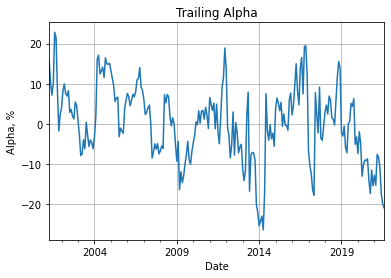

In [9]:
(pqr.metrics.trailing_alpha(portfolios[0], benchmark) * 100).plot()

plt.title("Trailing Alpha")
plt.xlabel("Date")
plt.ylabel("Alpha, %")
plt.grid();

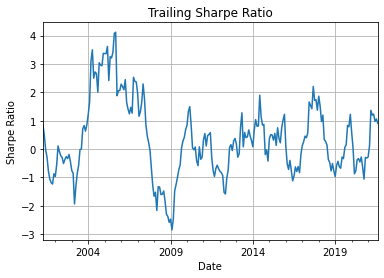

In [10]:
pqr.metrics.trailing_sharpe_ratio(portfolios[0]).plot()

plt.title("Trailing Sharpe Ratio")
plt.xlabel("Date")
plt.ylabel("Sharpe Ratio")
plt.grid();

In [11]:
pqr.metrics.max_drawdown(portfolios[0])

-0.6715492043914004

## Сравниваем портфели 

,Winners,Neutral 1,Losers,WML
"Monthly Mean Return, %",0.14 (0.37),-0.02 (-0.07),0.25 (0.72),-0.11 (-0.43)
"Monthly Volatility, %",6.22,5.09,5.63,4.00
"Maximum Drawdown, %",-67.15,-65.25,-73.21,-73.92
"Monthly Mean Excess Return, %",-0.17 (-0.81),-0.34 (-1.75),-0.06 (-0.31),-0.42 (-1.06)
"Monthly Alpha, %",-0.15 (-0.73),-0.26 (-1.50),-0.02 (-0.08),-0.14 (-0.55)
"Monthly Beta, %",0.95*** (24.77),0.77*** (24.21),0.85*** (24.66),0.09* (1.91)


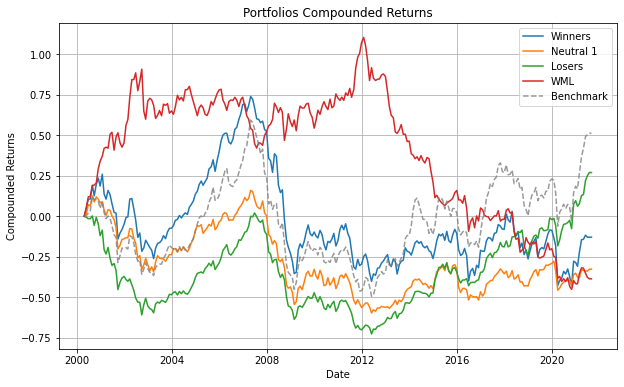

In [12]:
summary.display(portfolios)

## grid_search

In [13]:
def mean_transform_factory(looking, lag, holding):
    return pqr.utils.compose(
        pqr.utils.partial(pqr.factors.look_back_mean, period=looking),
        pqr.utils.partial(pqr.factors.lag, period=lag),
        pqr.utils.partial(pqr.factors.hold, period=holding),
    )


transforms_grid = {
    "(1, 0, 1)": mean_transform_factory(1, 0, 1),
    "(1, 1, 1)": mean_transform_factory(1, 1, 1),
    "(3, 0, 3)": mean_transform_factory(3, 0, 3),
    "(3, 1, 3)": mean_transform_factory(3, 1, 3),
    "(6, 0, 6)": mean_transform_factory(6, 0, 6),
    "(6, 1, 6)": mean_transform_factory(6, 1, 6),
    "(9, 0, 9)": mean_transform_factory(9, 0, 9),
    "(9, 1, 9)": mean_transform_factory(9, 1, 9),
    "(12, 0, 12)": mean_transform_factory(12, 0, 12),
    "(12, 1, 12)": mean_transform_factory(12, 1, 12),
}

results = pqr.factors.grid_search_factor_portfolios(    
    factor=pe,
    transforms=transforms_grid,
    metric=pqr.metrics.mean_return,
    strategies=pqr.factors.split_quantiles(3, "less"),
    allocator=pqr.equal_weights,
    calculator=returns_calculator,
    add_wml=True,
)

/home/akbabkin/programming/notebooks/venv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/akbabkin/programming/notebooks/venv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
/home/akbabkin/programming/notebooks/venv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1584: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


In [14]:
results

,Winners,Neutral 1,Losers,WML
"(1, 0, 1)",0.081074,0.064644,0.036096,0.044979
"(1, 1, 1)",0.074226,0.069362,0.035507,0.038719
"(3, 0, 3)",0.076663,0.067183,0.039177,0.037486
"(3, 1, 3)",0.066013,0.068885,0.037769,0.028244
"(6, 0, 6)",0.067252,0.063874,0.043479,0.023773
"(6, 1, 6)",0.061425,0.068701,0.037295,0.024130
"(9, 0, 9)",0.064241,0.066804,0.031704,0.032537
"(9, 1, 9)",0.061188,0.068095,0.028748,0.032439
"(12, 0, 12)",0.066965,0.067739,0.029883,0.037082
"(12, 1, 12)",0.068885,0.066858,0.029259,0.039625


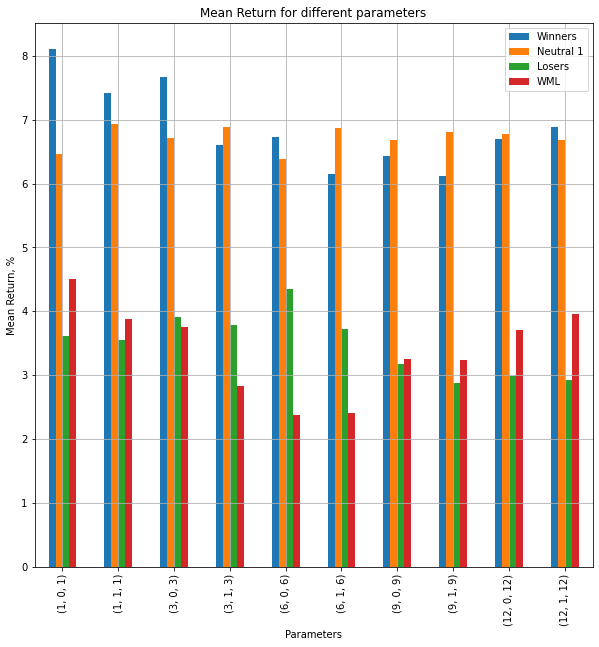

In [15]:
(results * 100).plot.bar(figsize=(10, 10))
plt.title("Mean Return for different parameters")
plt.xlabel("Parameters")
plt.ylabel("Mean Return, %")
plt.grid();